# FPSci Latency Study - Visualizations

This notebook creates publication-quality visualizations of the experimental
results examining how latency affects performance and Quality of Experience
(QoE) across five different game genres.

## Figure Order

1. **Figure 1** - Performance vs Latency (all 5 games, one plot)
2. **Figure 2** - QoE vs Latency (all 5 games, one plot)
3. **Figure 3** - Performance vs Latency (per-game detail subplots)
4. **Figure 4** - QoE vs Latency (per-game detail subplots)
5. **Figure 5** - Acceptability Rate vs Latency (per game)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

# ── Consistent game colour mapping (used across ALL figures) ──
GAME_ORDER = [
    'Dave the Diver',
    'Feeding Frenzy',
    'Fitts Law',
    'Half-Life 2',
    'Rocket League',
]
GAME_PALETTE = sns.color_palette('tab10', len(GAME_ORDER))
GAME_COLORS = dict(zip(GAME_ORDER, GAME_PALETTE))

# Markers per game (for combined plots)
GAME_MARKERS = dict(zip(GAME_ORDER, ['o', 's', 'D', '^', 'v']))

LATENCIES = [0, 75, 150, 225]

## Load Data


In [2]:
DATA_DIR = Path('../analysis/processed_data')
OUTPUT_DIR = Path('../analysis/figures')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load combined data
df = pd.read_csv(DATA_DIR / 'combined_data.csv')

# Verify game order matches data
game_display_set = set(df['game_display'].unique())
GAME_ORDER = [g for g in GAME_ORDER if g in game_display_set]
extra_games = sorted(g for g in game_display_set if g not in GAME_ORDER)
GAME_ORDER = GAME_ORDER + extra_games
# Refresh palette if order changed
GAME_PALETTE = sns.color_palette('tab10', len(GAME_ORDER))
GAME_COLORS = dict(zip(GAME_ORDER, GAME_PALETTE))
GAME_MARKERS = dict(zip(GAME_ORDER, ['o', 's', 'D', '^', 'v'][:len(GAME_ORDER)]))

print(f"Loaded {len(df)} observations")
print(f"Participants: {len(df['participant_id'].unique())}")
print(f"Games (ordered): {GAME_ORDER}")
print(f"Latency conditions: {sorted(df['latency_ms'].unique())}")

Loaded 488 observations
Participants: 27
Games (ordered): ['Dave the Diver', 'Feeding Frenzy', 'Fitts Law', 'Half-Life 2', 'Rocket League']
Latency conditions: [np.int64(0), np.int64(75), np.int64(150), np.int64(225)]


---
## Figure 1 — Performance vs Latency (All 5 Games)

Shows the mean normalised performance score (z-scored within each game) as a
function of added latency for every game on a single set of axes. Each game
has its own colour and marker (consistent throughout) with a linear trend
line. Error bars show 95% confidence intervals.


Saved: ../analysis/figures/fig1_performance_vs_latency_all_games.png


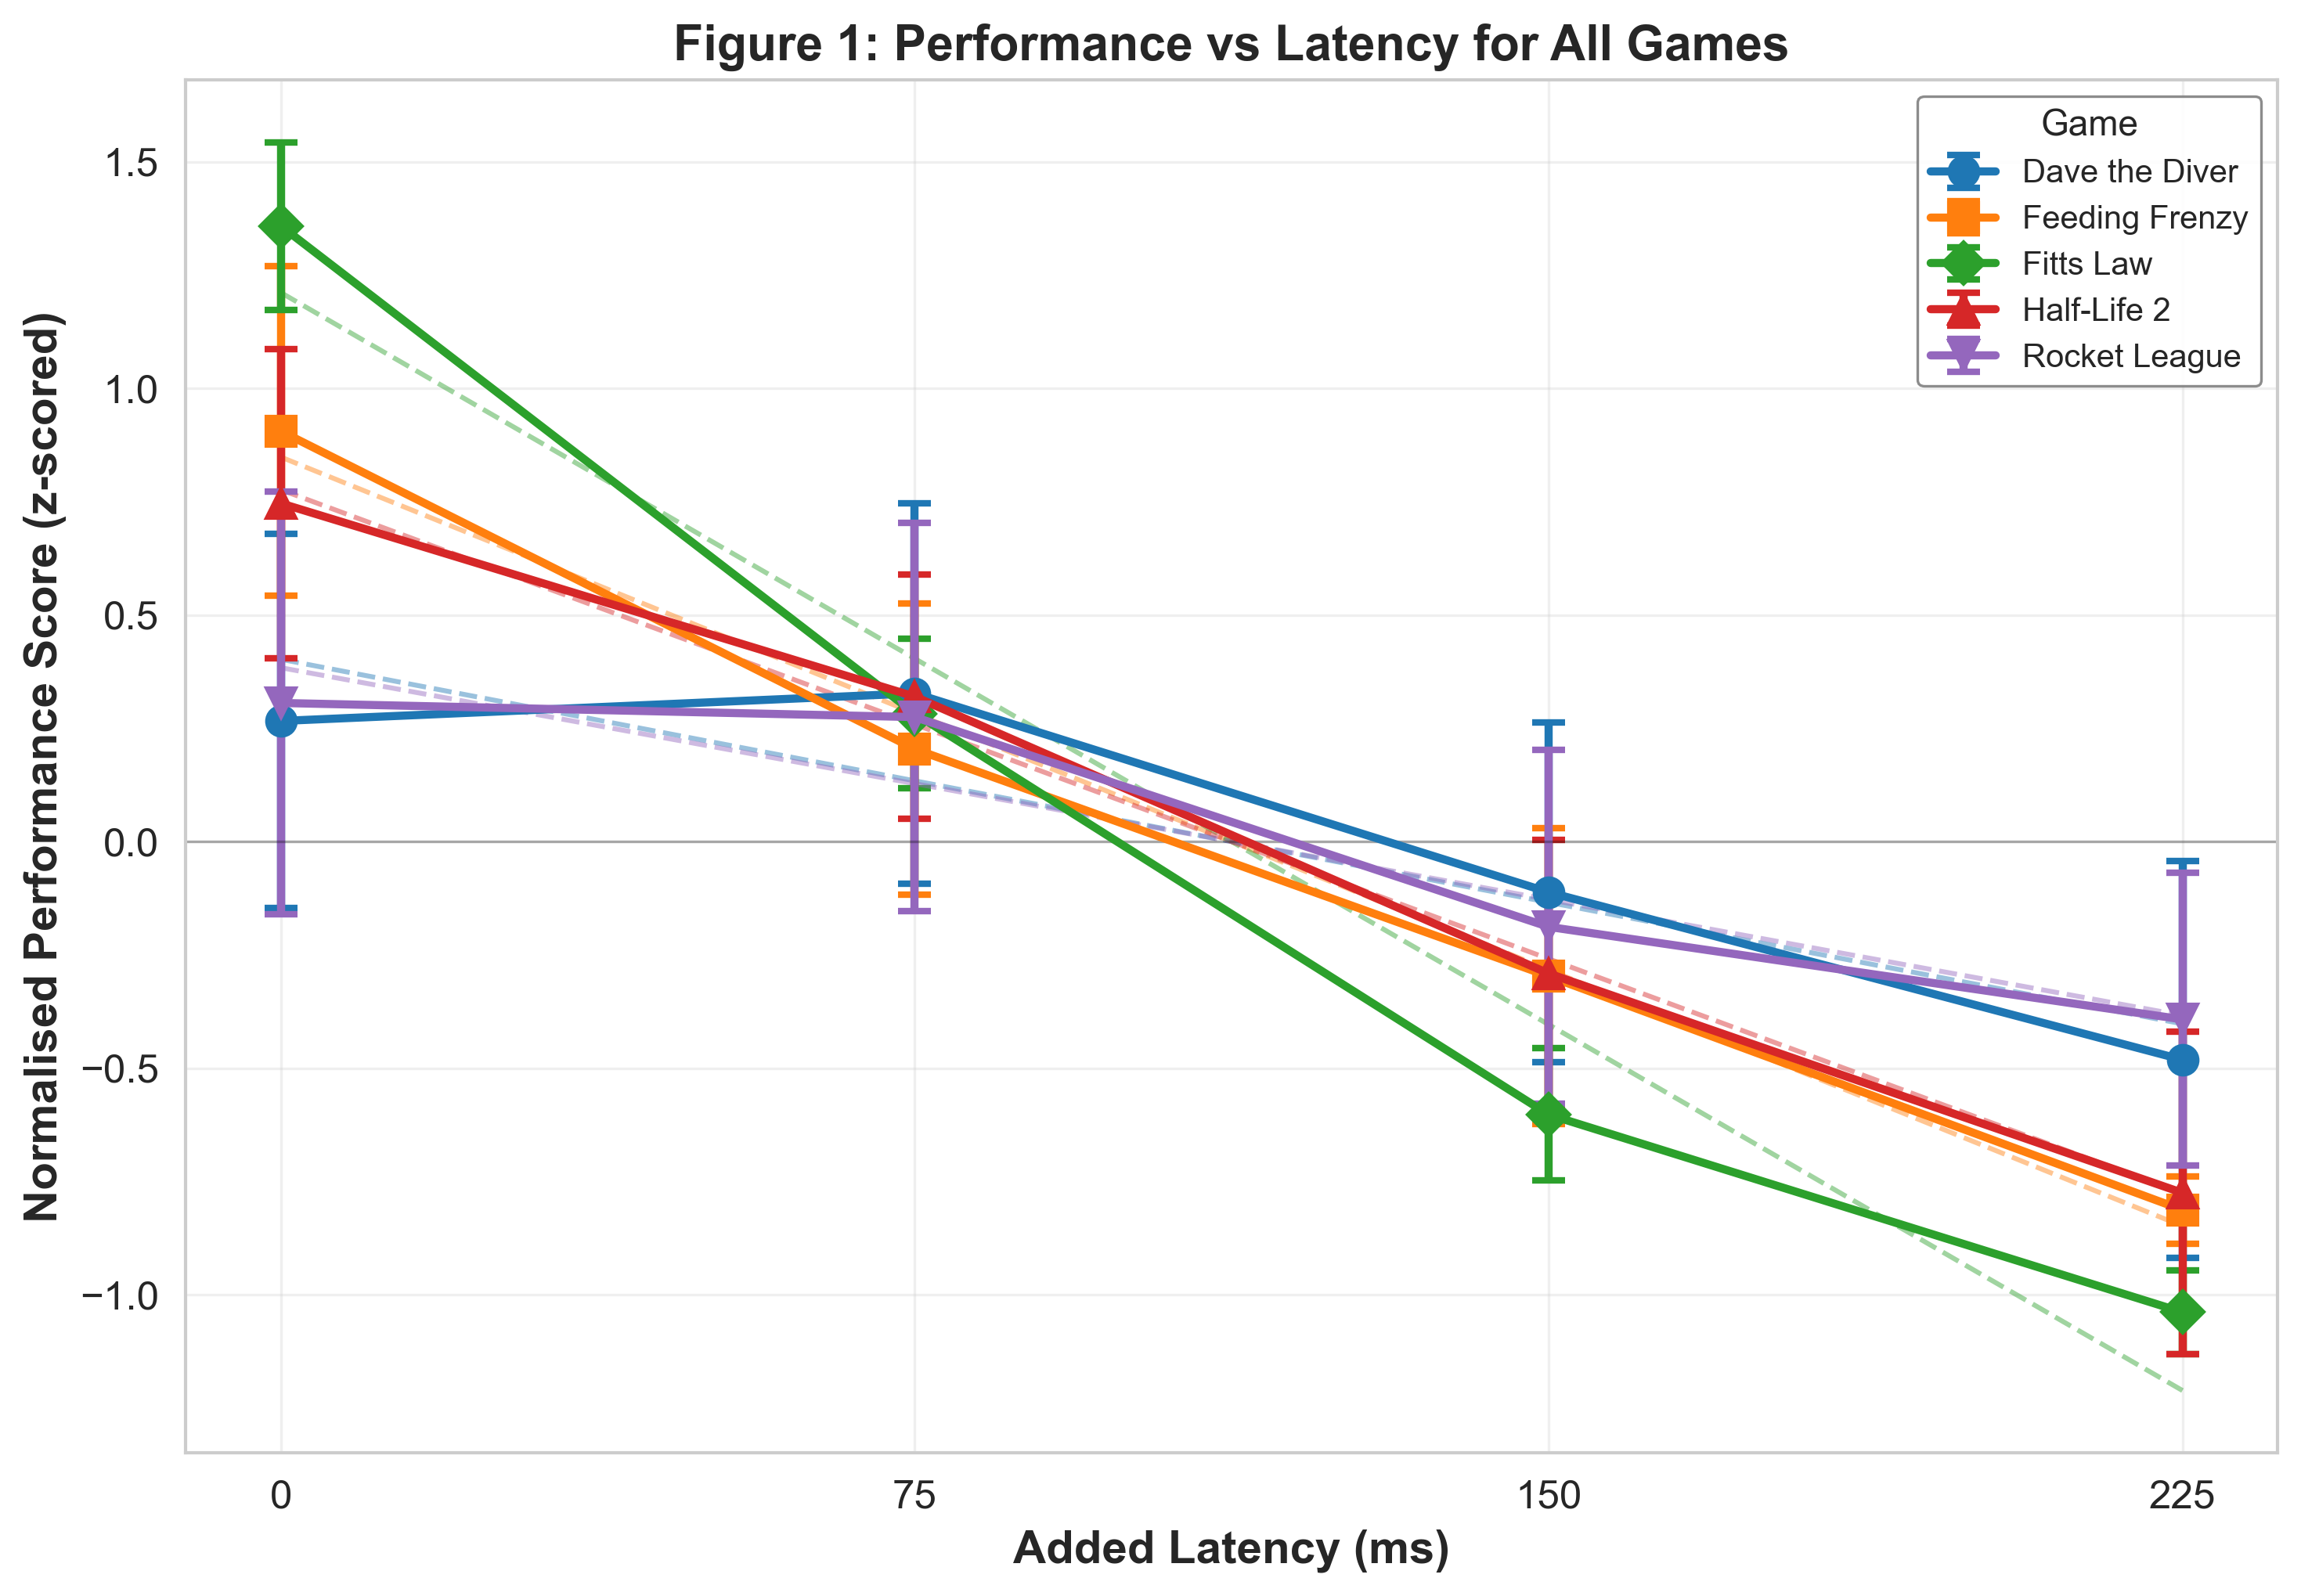

In [3]:
fig, ax = plt.subplots(figsize=(10, 7))

latency_range = np.linspace(0, 225, 200)

for game in GAME_ORDER:
    gdf = df[df['game_display'] == game]
    summary = gdf.groupby('latency_ms')['score_z'].agg(['mean', 'sem']).reset_index()
    summary['ci'] = summary['sem'] * 1.96
    color = GAME_COLORS[game]
    marker = GAME_MARKERS[game]

    # Mean + 95% CI
    ax.errorbar(
        summary['latency_ms'], summary['mean'], yerr=summary['ci'],
        marker=marker, markersize=9, linewidth=2.5, capsize=5, capthick=2,
        color=color, label=game,
    )

    # Linear trend line
    z = np.polyfit(gdf['latency_ms'], gdf['score_z'], 1)
    ax.plot(latency_range, np.polyval(z, latency_range),
            '--', color=color, alpha=0.45, linewidth=1.5)

ax.set_xlabel('Added Latency (ms)', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalised Performance Score (z-scored)', fontsize=14, fontweight='bold')
ax.set_title('Figure 1: Performance vs Latency for All Games',
             fontsize=15, fontweight='bold')
ax.set_xticks(LATENCIES)
ax.legend(title='Game', fontsize=10, title_fontsize=11, loc='best',
          framealpha=0.9, edgecolor='gray')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig1_performance_vs_latency_all_games.png',
            bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'fig1_performance_vs_latency_all_games.png'}")
plt.show()

---
## Figure 2 — QoE vs Latency (All 5 Games)

Shows mean QoE quality rating (1–5 scale) as a function of added latency for
every game. Same colour and marker coding as Figure 1.


Saved: ../analysis/figures/fig2_qoe_vs_latency_all_games.png


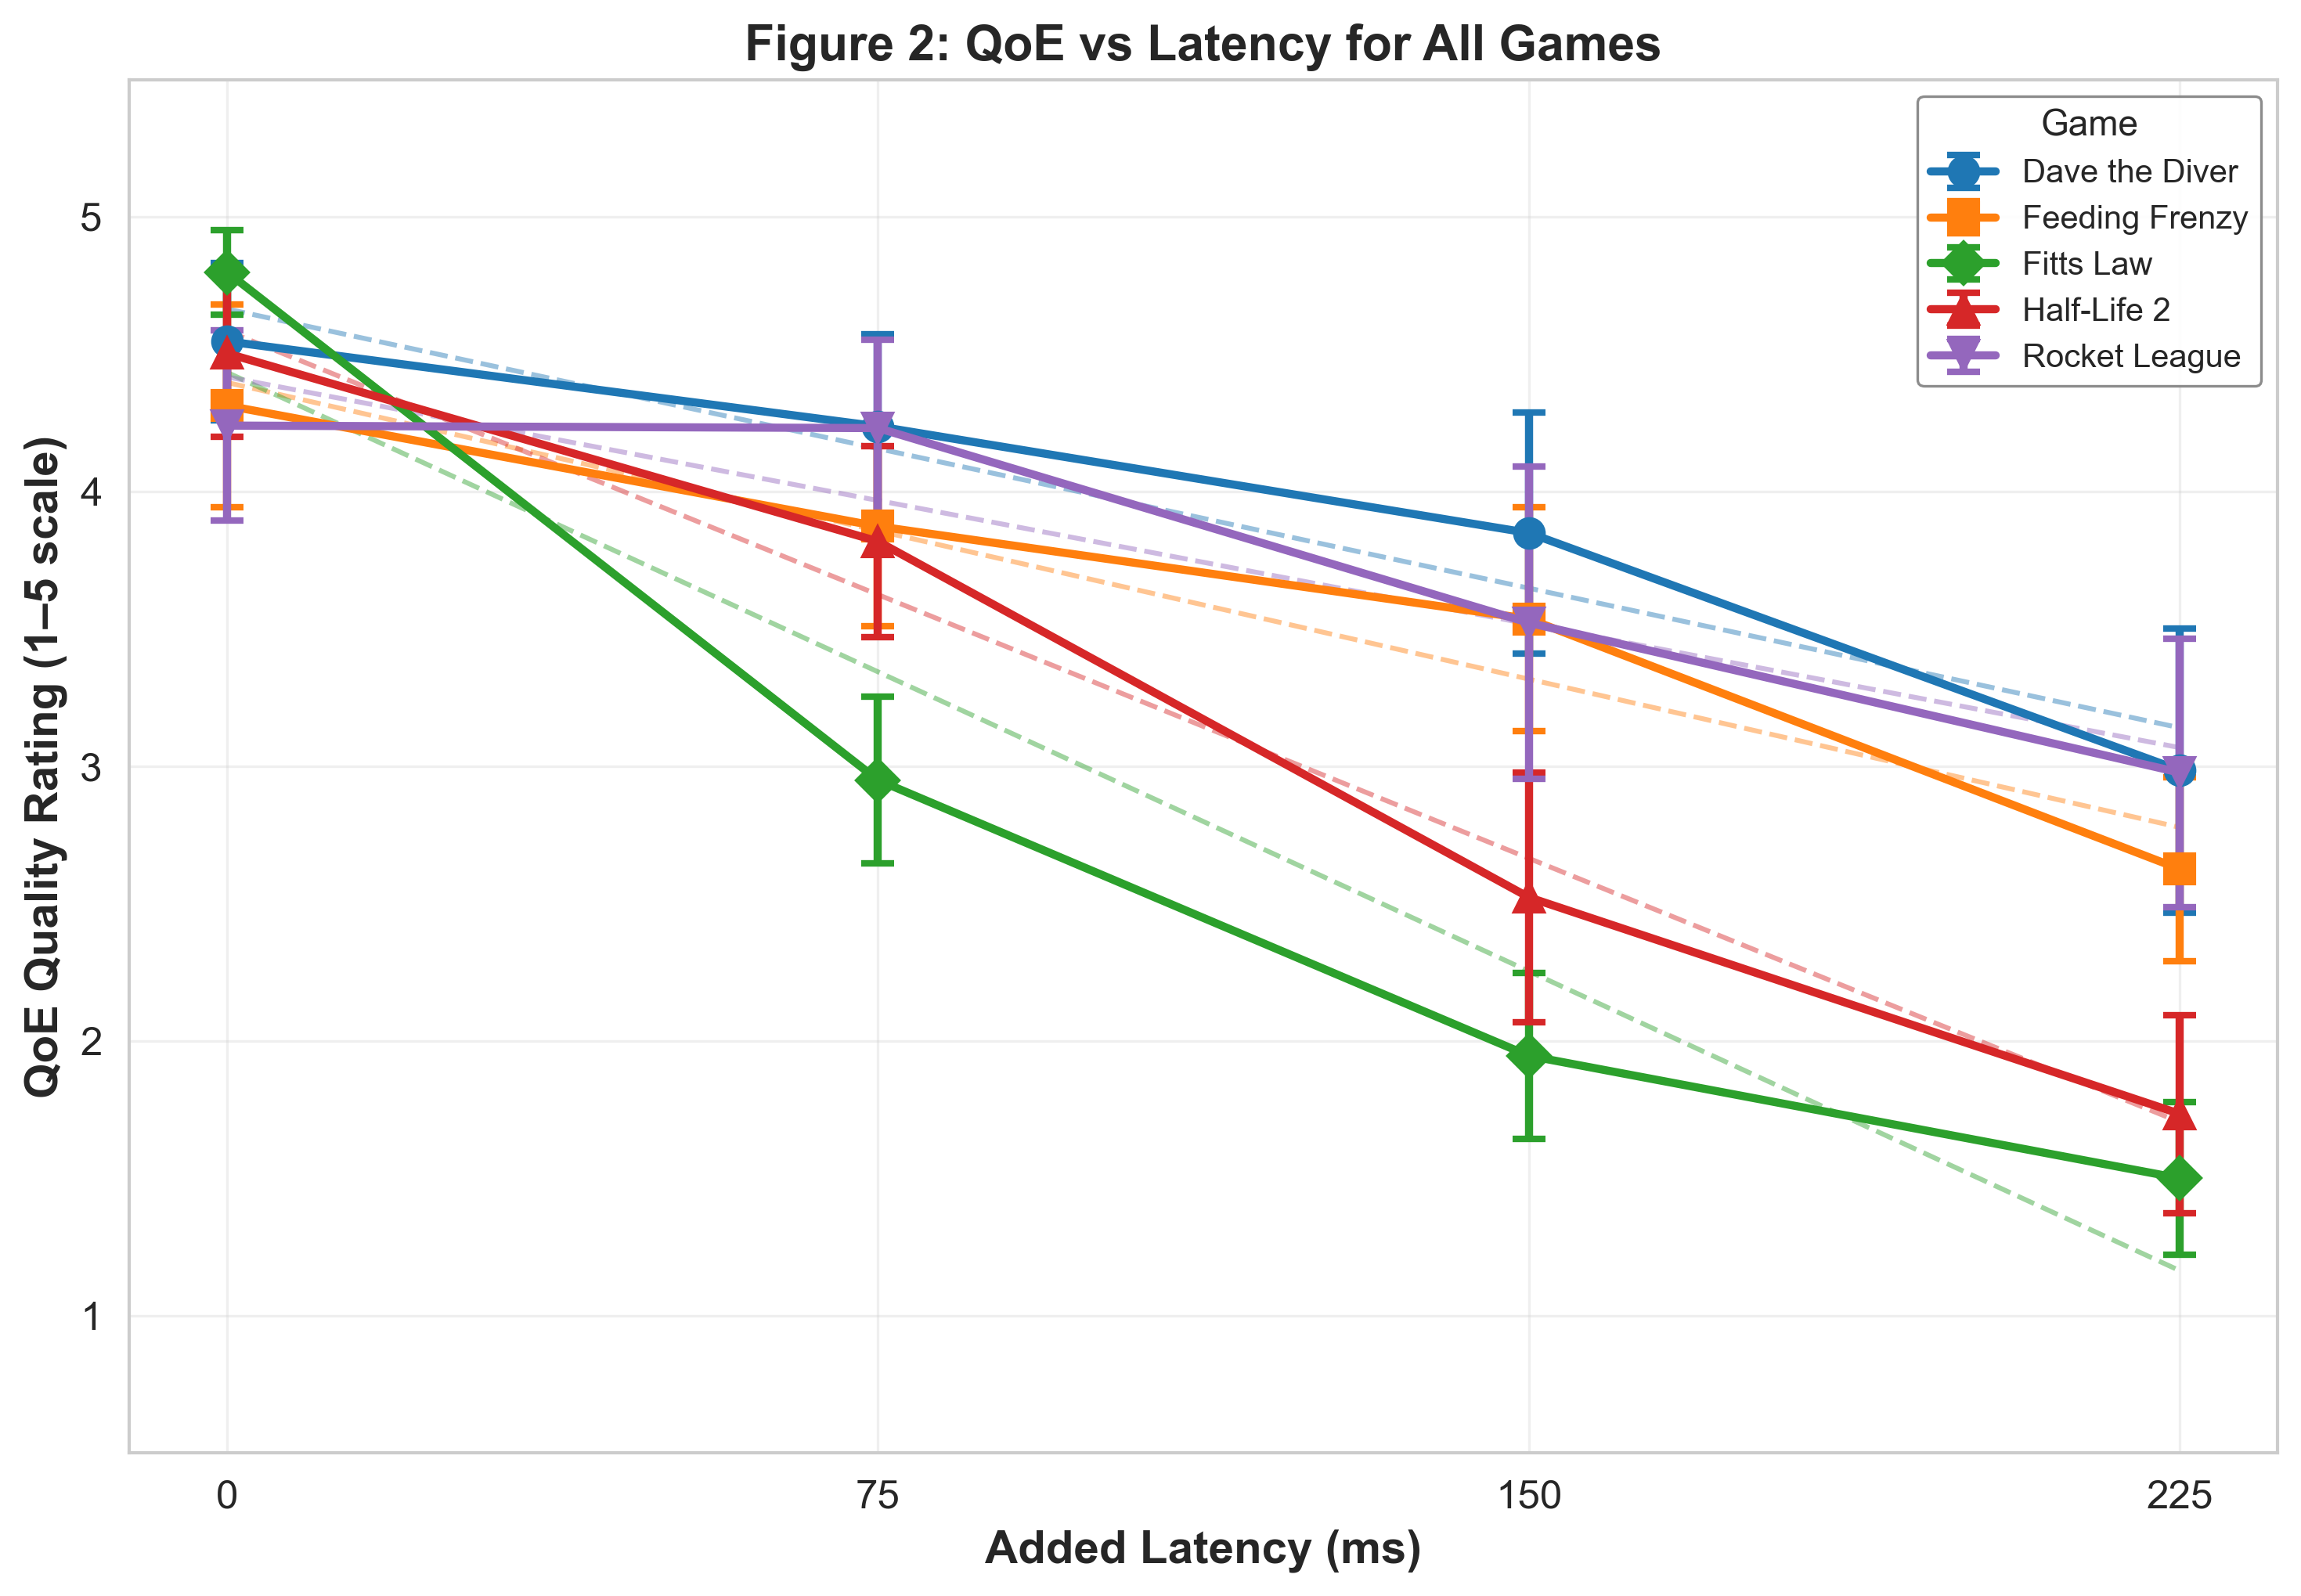

In [4]:
qoe_valid = df.dropna(subset=['quality_rating'])

fig, ax = plt.subplots(figsize=(10, 7))

for game in GAME_ORDER:
    gdf = qoe_valid[qoe_valid['game_display'] == game]
    summary = gdf.groupby('latency_ms')['quality_rating'].agg(['mean', 'sem']).reset_index()
    summary['ci'] = summary['sem'] * 1.96
    color = GAME_COLORS[game]
    marker = GAME_MARKERS[game]

    ax.errorbar(
        summary['latency_ms'], summary['mean'], yerr=summary['ci'],
        marker=marker, markersize=9, linewidth=2.5, capsize=5, capthick=2,
        color=color, label=game,
    )

    # Trend line
    z = np.polyfit(gdf['latency_ms'], gdf['quality_rating'], 1)
    ax.plot(latency_range, np.polyval(z, latency_range),
            '--', color=color, alpha=0.45, linewidth=1.5)

ax.set_xlabel('Added Latency (ms)', fontsize=14, fontweight='bold')
ax.set_ylabel('QoE Quality Rating (1\u20135 scale)', fontsize=14, fontweight='bold')
ax.set_title('Figure 2: QoE vs Latency for All Games',
             fontsize=15, fontweight='bold')
ax.set_xticks(LATENCIES)
ax.set_ylim(0.5, 5.5)
ax.legend(title='Game', fontsize=10, title_fontsize=11, loc='best',
          framealpha=0.9, edgecolor='gray')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig2_qoe_vs_latency_all_games.png',
            bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'fig2_qoe_vs_latency_all_games.png'}")
plt.show()

---
## Figure 3 — Performance vs Latency (Per-Game Detail)

One subplot per game showing individual participant trajectories (faint),
the group mean with 95% CI, and a linear trend line. Each subplot uses the
same colour as Figures 1 and 2 for its game. Pearson r and p-value annotated.


Saved: ../analysis/figures/fig3_performance_vs_latency_per_game.png


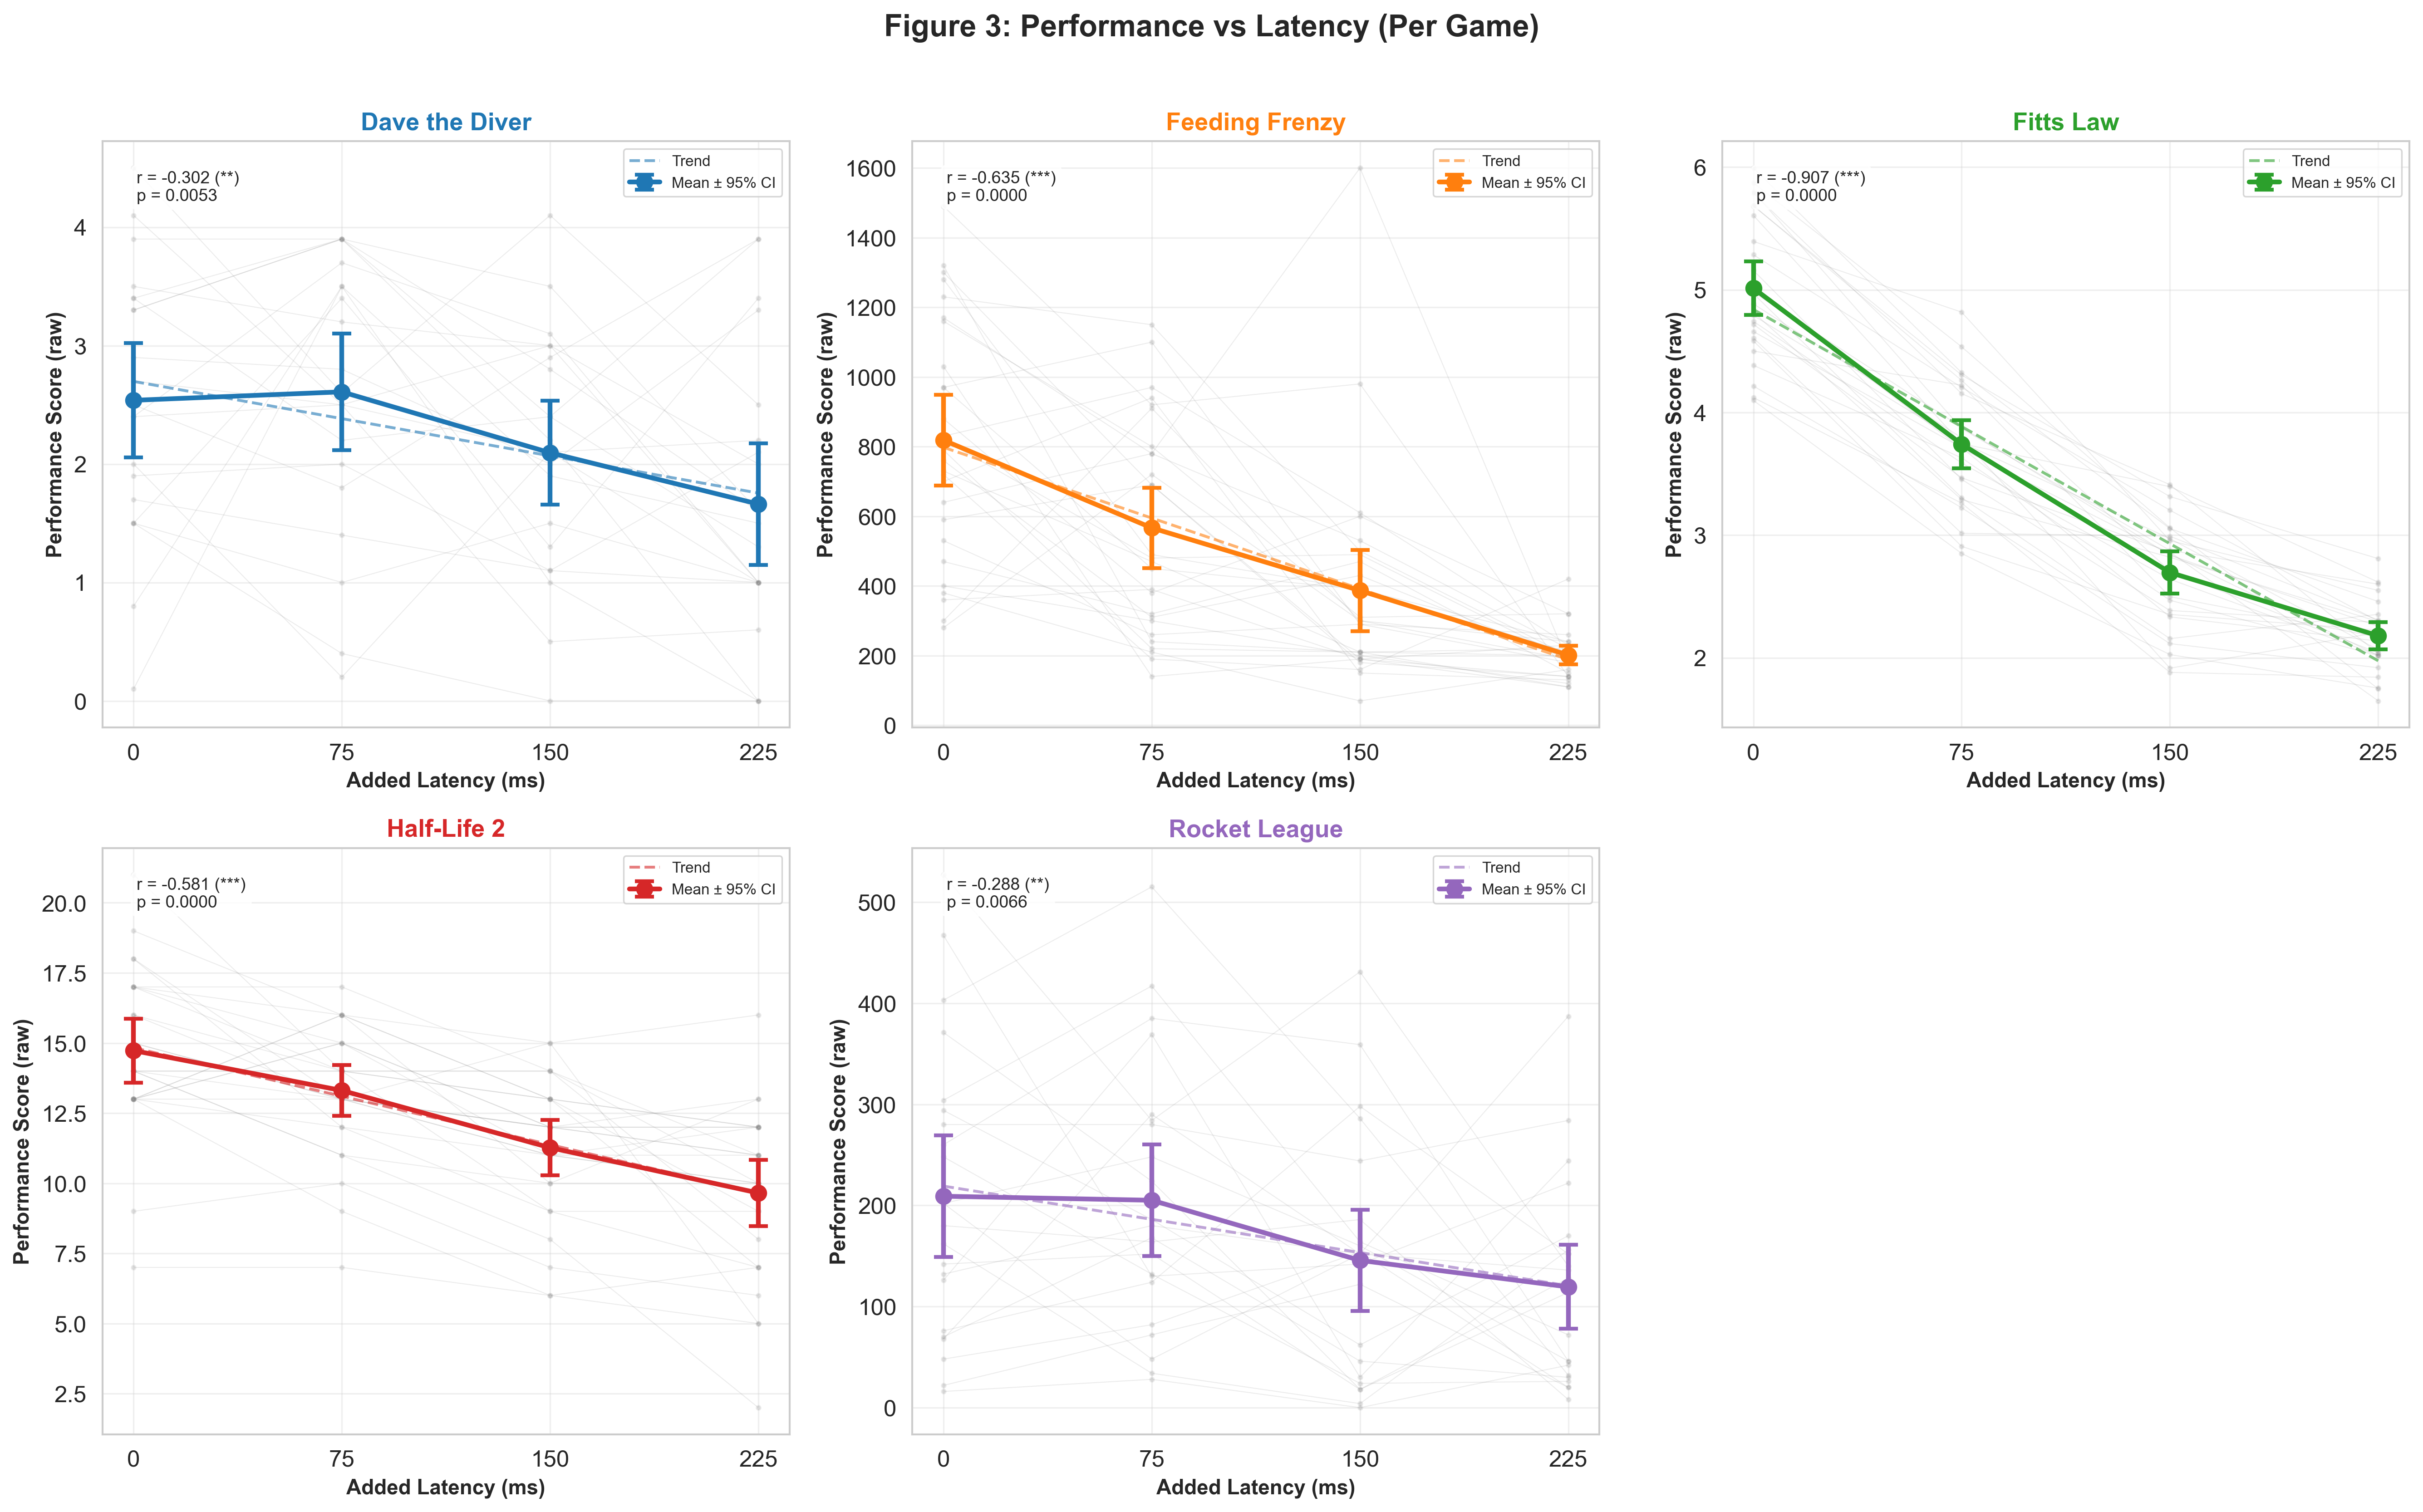

In [5]:
n_games = len(GAME_ORDER)
n_cols = 3
n_rows = (n_games + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()

for idx, game in enumerate(GAME_ORDER):
    ax = axes[idx]
    game_df = df[df['game_display'] == game].copy()
    color = GAME_COLORS[game]

    # Individual participant trajectories
    for pid in game_df['participant_id'].unique():
        pdata = game_df[game_df['participant_id'] == pid].sort_values('latency_ms')
        ax.plot(pdata['latency_ms'], pdata['score'],
                alpha=0.15, color='gray', linewidth=0.5, marker='o', markersize=2)

    # Mean + CI
    summary = game_df.groupby('latency_ms')['score'].agg(['mean', 'sem']).reset_index()
    summary['ci'] = summary['sem'] * 1.96
    ax.errorbar(
        summary['latency_ms'], summary['mean'], yerr=summary['ci'],
        marker='o', markersize=8, linewidth=2.5, capsize=5, capthick=2,
        color=color, label='Mean \u00b1 95% CI',
    )

    # Trend line
    z = np.polyfit(game_df['latency_ms'], game_df['score'], 1)
    ax.plot(latency_range, np.polyval(z, latency_range),
            '--', color=color, alpha=0.6, linewidth=1.5, label='Trend')

    # Pearson r
    r, p_val = stats.pearsonr(game_df['latency_ms'], game_df['score'])
    sig = '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else 'ns'))
    ax.text(0.05, 0.95, f'r = {r:.3f} ({sig})\np = {p_val:.4f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

    ax.set_title(game, fontsize=13, fontweight='bold', color=color)
    ax.set_xlabel('Added Latency (ms)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Performance Score (raw)', fontsize=11, fontweight='bold')
    ax.set_xticks(LATENCIES)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

# Remove unused subplots
for j in range(n_games, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Figure 3: Performance vs Latency (Per Game)',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig3_performance_vs_latency_per_game.png',
            bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'fig3_performance_vs_latency_per_game.png'}")
plt.show()

---
## Figure 4 — QoE vs Latency (Per-Game Detail)

Same layout as Figure 3 but for QoE quality rating. Consistent game colours.


Saved: ../analysis/figures/fig4_qoe_vs_latency_per_game.png


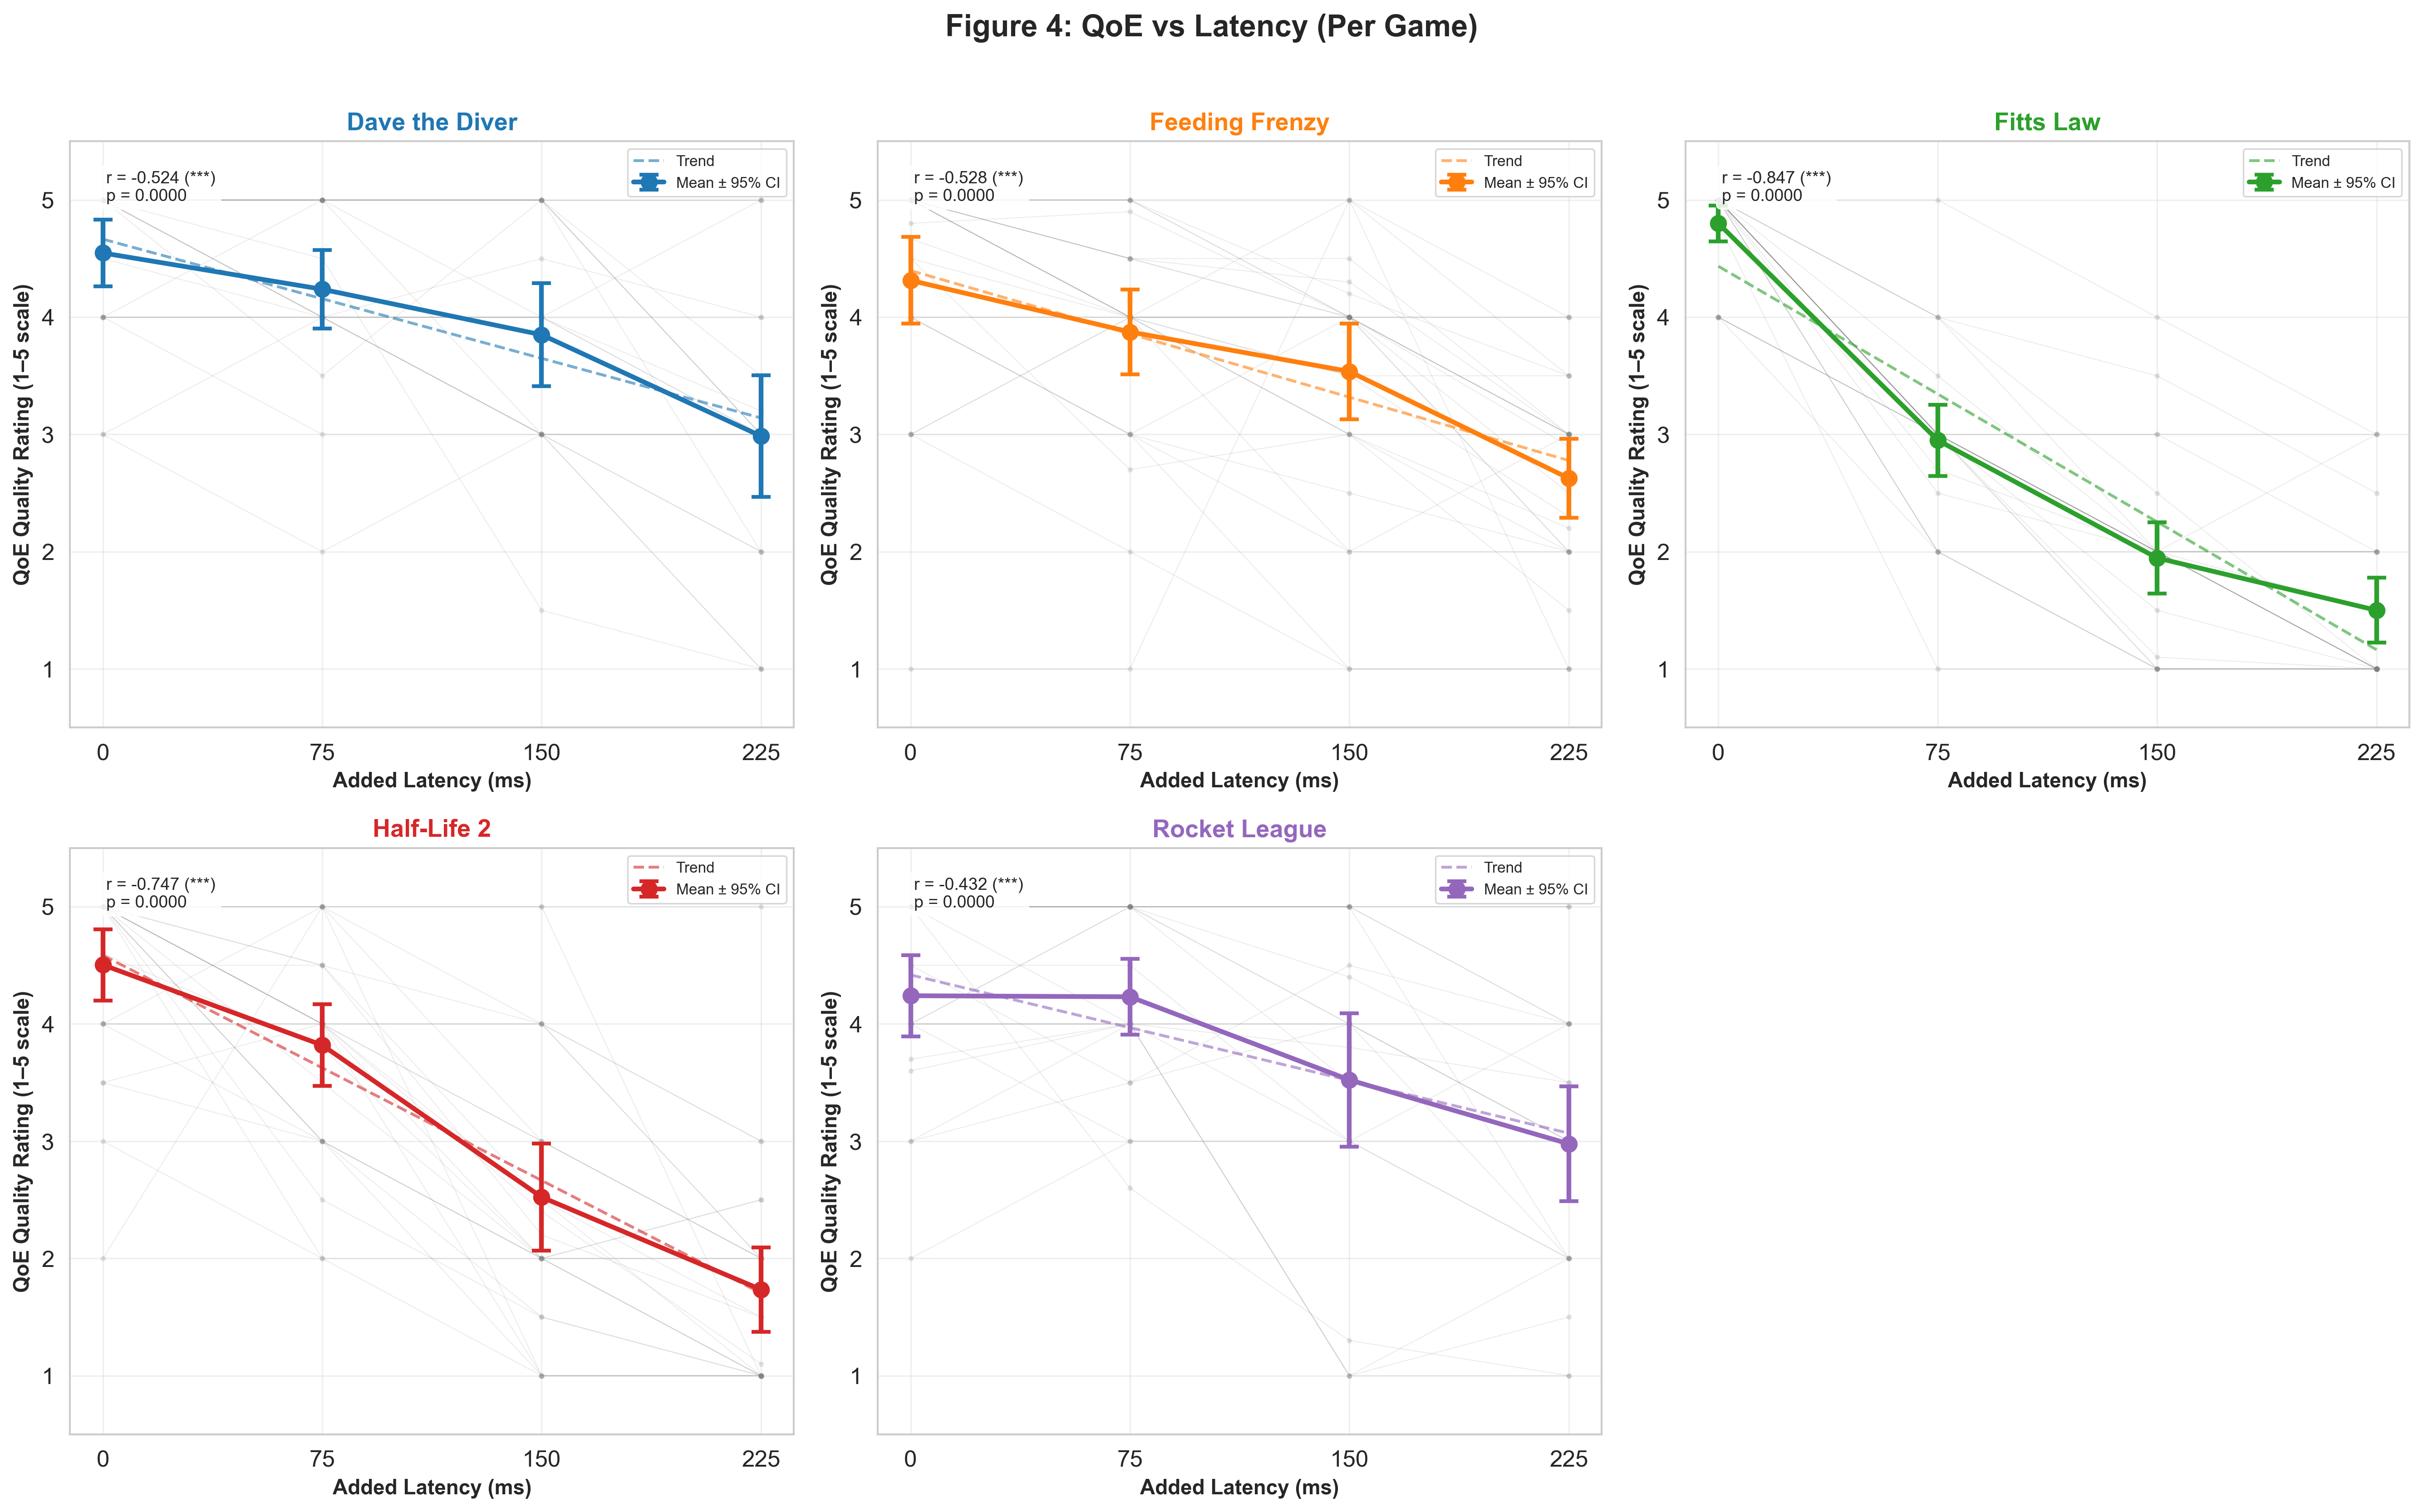

In [6]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5.5 * n_rows))
axes = axes.flatten()

for idx, game in enumerate(GAME_ORDER):
    ax = axes[idx]
    game_df = qoe_valid[qoe_valid['game_display'] == game].copy()
    color = GAME_COLORS[game]

    # Individual participant trajectories
    for pid in game_df['participant_id'].unique():
        pdata = game_df[game_df['participant_id'] == pid].sort_values('latency_ms')
        ax.plot(pdata['latency_ms'], pdata['quality_rating'],
                alpha=0.15, color='gray', linewidth=0.5, marker='o', markersize=2)

    # Mean + CI
    summary = game_df.groupby('latency_ms')['quality_rating'].agg(['mean', 'sem']).reset_index()
    summary['ci'] = summary['sem'] * 1.96
    ax.errorbar(
        summary['latency_ms'], summary['mean'], yerr=summary['ci'],
        marker='o', markersize=8, linewidth=2.5, capsize=5, capthick=2,
        color=color, label='Mean \u00b1 95% CI',
    )

    # Trend line
    z = np.polyfit(game_df['latency_ms'], game_df['quality_rating'], 1)
    ax.plot(latency_range, np.polyval(z, latency_range),
            '--', color=color, alpha=0.6, linewidth=1.5, label='Trend')

    # Pearson r
    r, p_val = stats.pearsonr(game_df['latency_ms'], game_df['quality_rating'])
    sig = '***' if p_val < 0.001 else ('**' if p_val < 0.01 else ('*' if p_val < 0.05 else 'ns'))
    ax.text(0.05, 0.95, f'r = {r:.3f} ({sig})\np = {p_val:.4f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

    ax.set_title(game, fontsize=13, fontweight='bold', color=color)
    ax.set_xlabel('Added Latency (ms)', fontsize=11, fontweight='bold')
    ax.set_ylabel('QoE Quality Rating (1\u20135 scale)', fontsize=11, fontweight='bold')
    ax.set_xticks(LATENCIES)
    ax.set_ylim(0.5, 5.5)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='best')

# Remove unused subplots
for j in range(n_games, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Figure 4: QoE vs Latency (Per Game)',
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig4_qoe_vs_latency_per_game.png',
            bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'fig4_qoe_vs_latency_per_game.png'}")
plt.show()

---
## Figure 5 — Acceptability Rate vs Latency (Per Game)

Shows the percentage of participants who rated each latency condition as
"acceptable", broken down by game with consistent colour coding. This lets
us compare which genres lose acceptability fastest as latency increases.


Saved: ../analysis/figures/fig5_acceptability_vs_latency.png


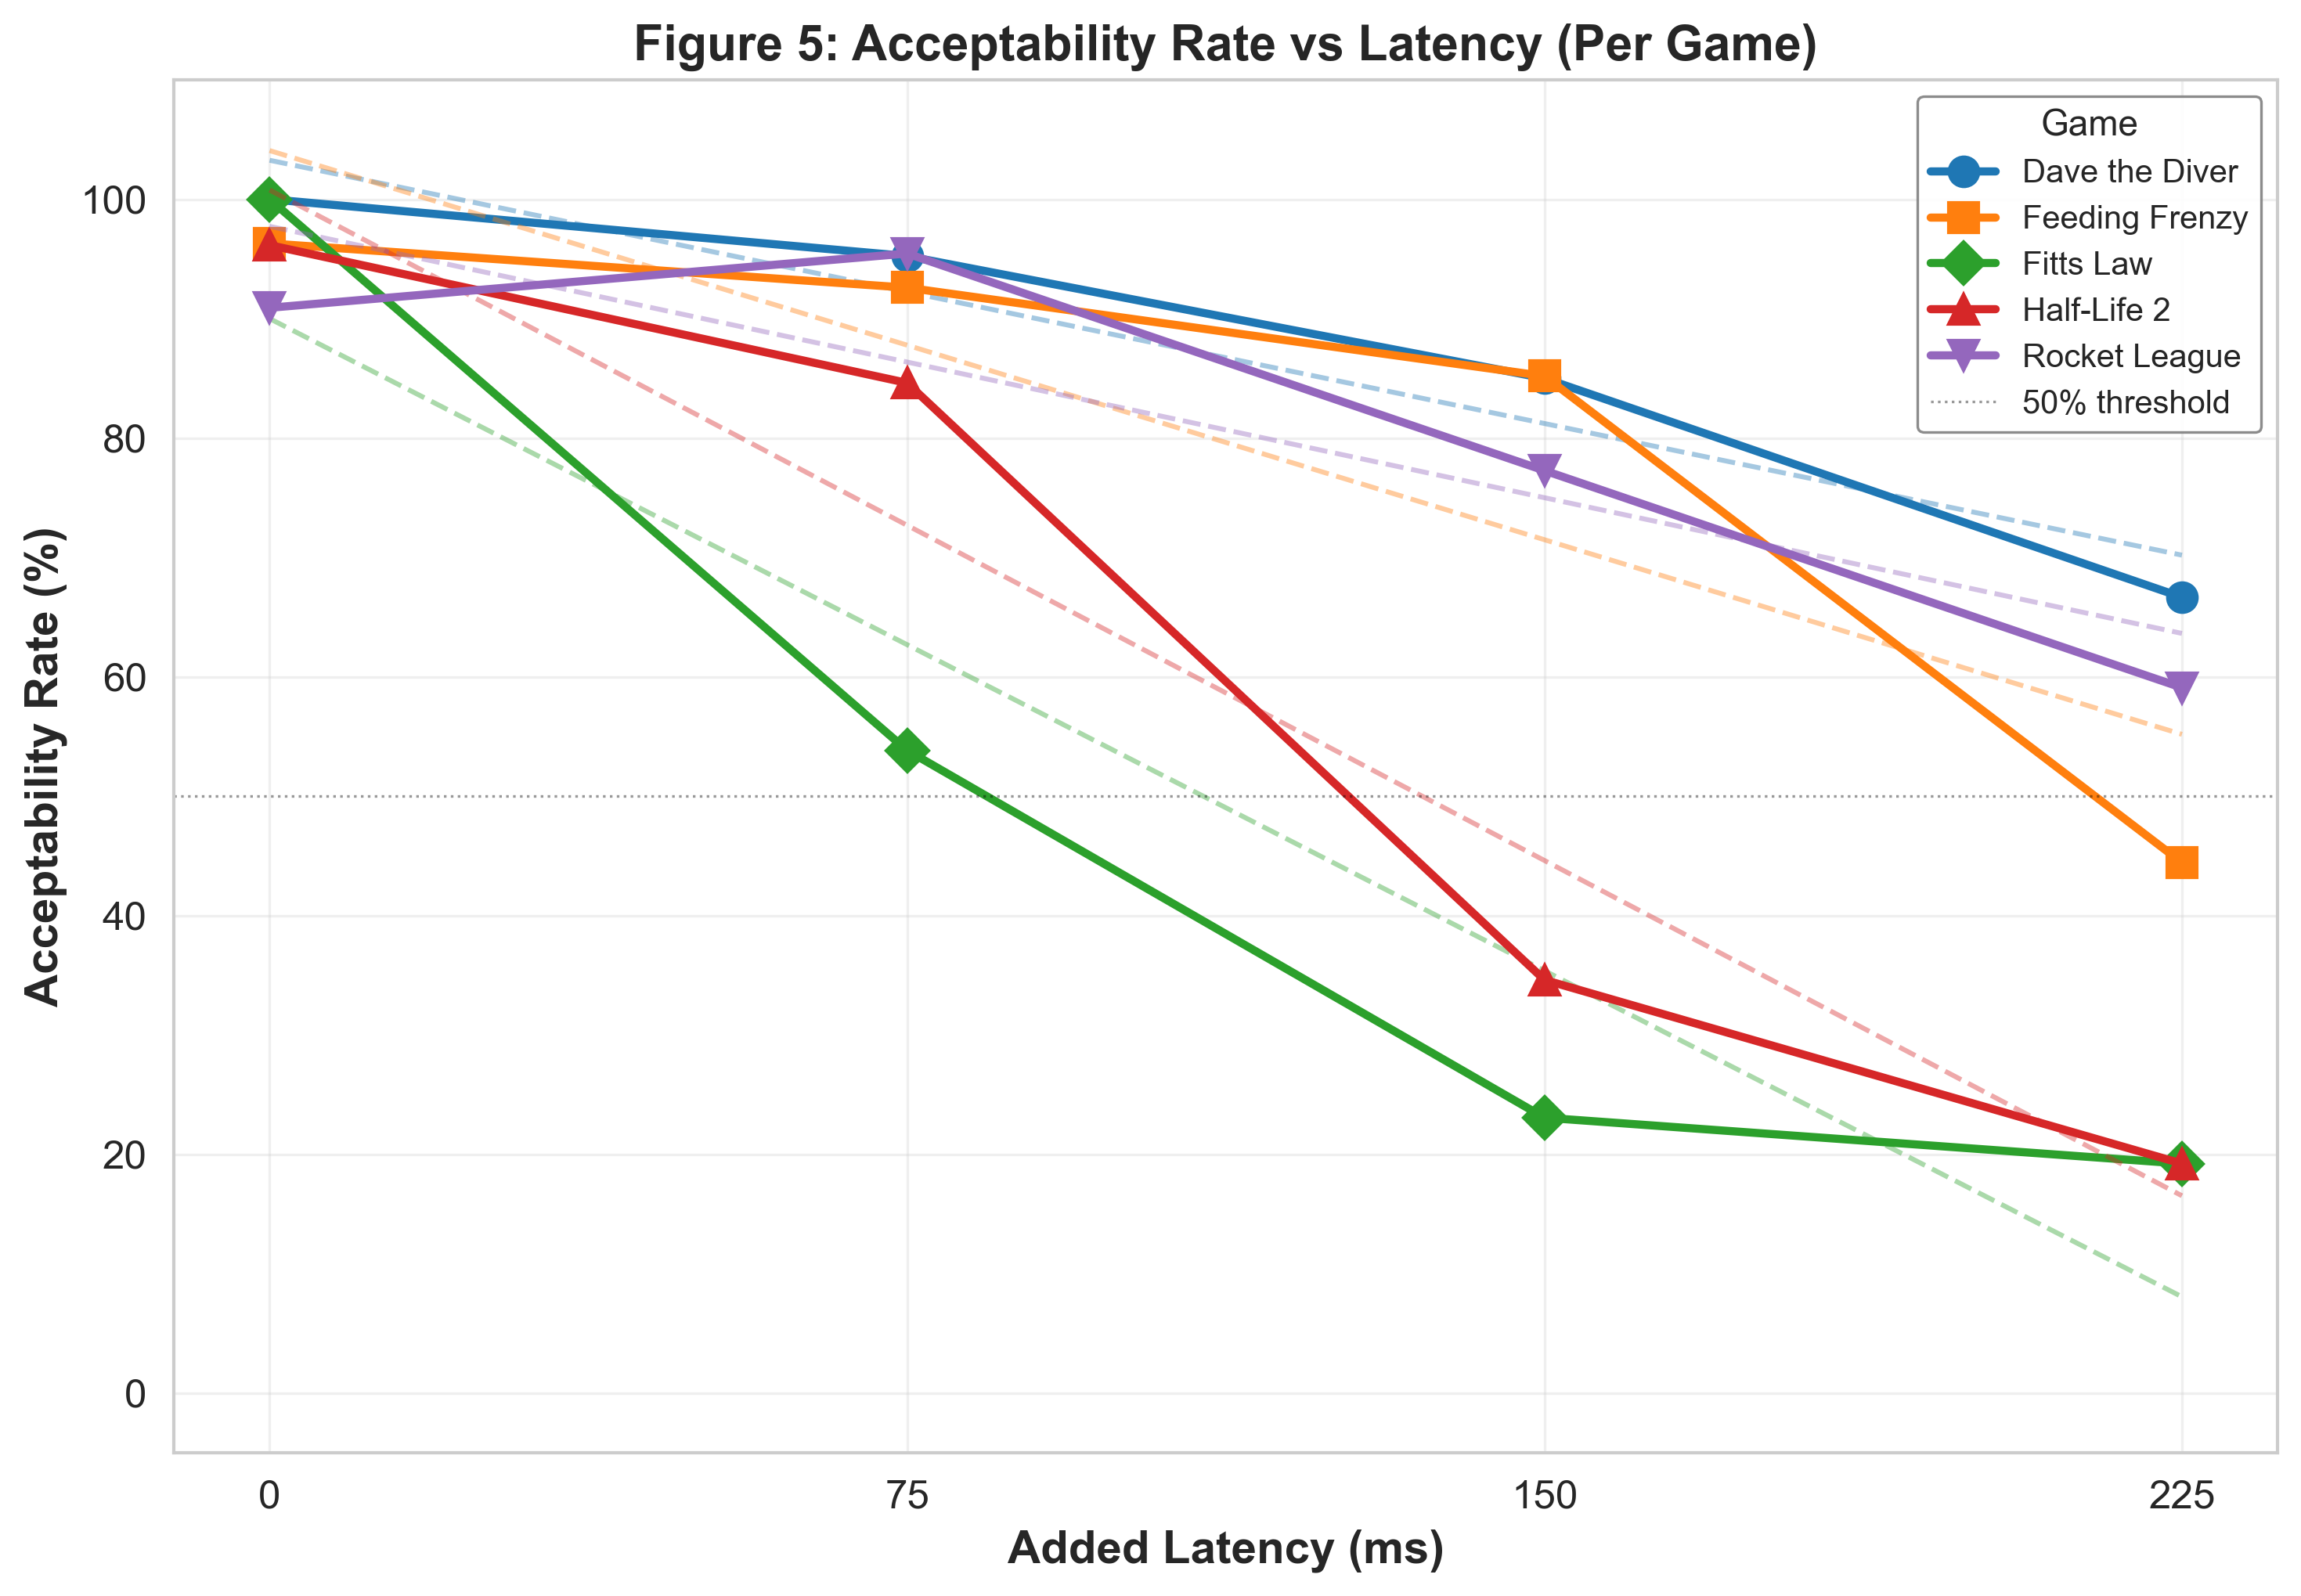

In [7]:
accept_valid = df.dropna(subset=['acceptable'])

fig, ax = plt.subplots(figsize=(10, 7))

for game in GAME_ORDER:
    gdf = accept_valid[accept_valid['game_display'] == game]
    summary = gdf.groupby('latency_ms')['acceptable'].mean().reset_index()
    summary['pct'] = summary['acceptable'] * 100
    color = GAME_COLORS[game]
    marker = GAME_MARKERS[game]

    ax.plot(
        summary['latency_ms'], summary['pct'],
        marker=marker, markersize=9, linewidth=2.5,
        color=color, label=game,
    )

    # Linear trend line
    z = np.polyfit(summary['latency_ms'], summary['pct'], 1)
    ax.plot(latency_range, np.polyval(z, latency_range),
            '--', color=color, alpha=0.4, linewidth=1.5)

ax.set_xlabel('Added Latency (ms)', fontsize=14, fontweight='bold')
ax.set_ylabel('Acceptability Rate (%)', fontsize=14, fontweight='bold')
ax.set_title('Figure 5: Acceptability Rate vs Latency (Per Game)',
             fontsize=15, fontweight='bold')
ax.set_xticks(LATENCIES)
ax.set_ylim(-5, 110)
ax.axhline(y=50, color='black', linewidth=0.8, linestyle=':', alpha=0.4,
           label='50% threshold')
ax.legend(title='Game', fontsize=10, title_fontsize=11, loc='best',
          framealpha=0.9, edgecolor='gray')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig5_acceptability_vs_latency.png',
            bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'fig5_acceptability_vs_latency.png'}")
plt.show()